# Team Assignment 4

Team Sakia: Iara Ravagni and Sakshee Patil

Date: 09-24-2024

Requirements: Before starting, install the requirements listed on the file requirements.txt plus bs4

## Import libraries

In [208]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Download CSV Files

This step downloads the dataset from the original [GitHub repository](https://github.com/Welltory/hrv-covid19/tree/master).

In [209]:
# Define the URL of the GitHub data folder
url = 'https://github.com/Welltory/hrv-covid19/tree/master/data'

# Send a GET request to the URL
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find all links to CSV files
csv_links = set()
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.csv'):
        csv_links.add(f'https://raw.githubusercontent.com{href.replace("blob/", "")}')

# Create a directory to save the CSV files
os.makedirs('data', exist_ok=True)

csv_data = {}

# Download each CSV file
for csv_url in csv_links:
    filename = os.path.join('data', csv_url.split('/')[-1])
    try:
        response = requests.get(csv_url)
        response.raise_for_status()  # Raise an error for bad responses
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f'Downloaded: {filename}')

        csv_data[filename] = pd.read_csv(filename)
    except requests.exceptions.HTTPError as e:
        print(f'Error downloading {csv_url}: {e}')


Downloaded: data\participants.csv
Downloaded: data\weather.csv
Downloaded: data\scales_description.csv
Downloaded: data\heart_rate.csv
Downloaded: data\hrv_measurements.csv
Downloaded: data\sleep.csv
Downloaded: data\surveys.csv
Downloaded: data\blood_pressure.csv
Downloaded: data\wearables.csv


## Exploratory Data Analysis

### Data context and Sampling

This dataset was created by the Welltory team's open research conducted in 2020, aimed at detecting patterns in COVID-19 progression and recovery. Users who tested positive for COVID-19 tracked their symptoms and heart rate variability using the Welltory app. They have collected:

1. Heart rate variability measurements
2. Data from user-connected gadgets
3. Clinically validated physical and mental health assessments


### Data Structure

Interpreting the following
1. Dimensions of every dataset
2. Analyzing the number of unique use codes per dataset
3. Data types of the variables in each dataset
4. Checking for missing values per feature per dataset

In [210]:
for filename, df in csv_data.items():
    print(f'Data Structure for file: {filename}')
    print('--------------------------------------')
    print(f'Dimensions: {df.shape}')
    if filename != 'data\\scales_description.csv':
        print(f'Number of unique user_codes: {df['user_code'].nunique()}')
    print(f'Data Types:\n{df.dtypes}')
    print(f'Missing values:\n{df.isnull().sum()}\n\n')

Data Structure for file: data\participants.csv
--------------------------------------
Dimensions: (185, 8)
Number of unique user_codes: 185
Data Types:
user_code          object
gender             object
age_range          object
city               object
country            object
height            float64
weight            float64
symptoms_onset     object
dtype: object
Missing values:
user_code          0
gender             0
age_range          0
city              12
country            6
height             2
weight             0
symptoms_onset    38
dtype: int64


Data Structure for file: data\weather.csv
--------------------------------------
Dimensions: (1717, 7)
Number of unique user_codes: 104
Data Types:
user_code                object
day                      object
avg_temperature_C       float64
atmospheric_pressure    float64
precip_intensity        float64
humidity                float64
clouds                  float64
dtype: object
Missing values:
user_code               0

**Interpretation**

There are a total of 9 csv files logging data about various metrics like blood-pressure, heart-rate, etc:
- **participants.csv** - There are a total of 185 participants
- sleep.csv: Contains details of 10 unique participants which is 5% of the total participants. Moreover, out of 12 features, 7 features contain more than ~93% missing values. Thus, we will exclude this file from further analysis.
- **scales_description.csv** - There are no NaN values. It also contains "scale" and "value" features that can be left-joined with surveys.csv.
- **weather.csv** - The file contains data from 104 users with no missing value. For the purpose of this analysis, we feel that metrics such as HRV measurements play a more significant role for COVID 19 symptoms data as opposed to the weather. However, we will explore any possible co-relation below.
- blood_pressure.csv - contains data from 28 unique participants which is only 15% of the total pool of participants. Half the features in the data also contain more than 58% missing values.
- **hrv_measurements.csv** - contains data for all 185 participants with a majority of complete features. The two features with around 50% missing values can be dropped.
- **surveys.csv** - contains no NaN values and can be merged with scales_description to get a more holistic dataset
- wearables.csv - Although it contains data from 79 participants, majority of the features contain missing values making the overall data redundant.
- heart_rate.csv - Contains data from 79 participants. Although, hrv measurements is a more complete file with 'bpm' feature which is analogous to the main heart rate feature of this dataset.

8 out of these 9 csv files contain the user-code column which are the participants involved in the study whose metadata can be found in participants.csv. Based on the shape of this table, we can see that there were 185 participants involved in the study.

The file scales_description.csv does not contain data that can directly be associated with a given user-code and is more of metadata about various 'scale' metrics and corresponding values such as Covid cough, Covid fever etc.

The dataset contains multiple missing values across most files, so the first priority is to handle these missing values before proceeding with any analysis.

In [211]:
# Keeping selected datasets

df_participants = csv_data['data\\participants.csv']
df_hrv = csv_data['data\\hrv_measurements.csv']
df_weather = csv_data['data\\weather.csv']

df_sur_scale = csv_data['data\\surveys.csv'].merge(csv_data['data\\scales_description.csv'], left_on=['scale', 'value'], right_on=['Scale', 'Value'], how='left')
df_sur_scale = df_sur_scale.drop(columns=['Scale', 'Value'], axis=1)

### Handling missing values

#### participants.csv

1. Analysing the anomaly in the Symptoms_Onset column: Check for years before 2020 since COVID-19 started December 2019 and any symptoms starting before that time are errorneous data points and should be converted to NaN

2. Dealing with NaN values: Check whether there are any missing country values where city is available. If yes, fill the appropriate country, else replace NaN values of city and country with "Unknown" creating a new category

3. For missing values of height, we will simply fill it with the mean value of the height with other people of the same weight +- 2kg

In [212]:
# Convert symptoms_onset to datetime, coercing errors to NaT
df_participants['symptoms_onset'] = pd.to_datetime(df_participants['symptoms_onset'], errors='coerce')

# Get the list of years, excluding NaT values
year = df_participants['symptoms_onset'].dropna().dt.year.tolist()

# Find unique years
unique_years = set(year)
print("Unique Years:", unique_years)

# Get years before 2020
years_before_2020 = [x for x in year if x < 2020]
print("Years Before 2020:", years_before_2020)

# Apply cutoff date, leaving earlier dates as NaT
cutoff_date = pd.Timestamp('2019-12-01')
df_participants.loc[df_participants['symptoms_onset'] < cutoff_date, 'symptoms_onset'] = pd.NaT


Unique Years: {1984, 1987, 2020, 2021, 2022, 1993, 1999, 1967, 1968, 2000, 1975, 1977, 1981, 1982}
Years Before 2020: [1999, 1987, 1981, 1984, 1982, 1967, 1968, 1993, 1975, 1977, 2000]


In [213]:
# Countries and cities

df_participants[df_participants['country'].isna()]

,user_code,gender,age_range,city,country,height,weight,symptoms_onset
94,7badc26d11,m,45-54,NaN,NaN,187.96,97.931,NaT
107,89ec5a2500,f,25-34,NaN,NaN,172.00,73.500,2020-03-28
127,a78719c4a1,f,35-44,NaN,NaN,160.02,68.492,NaT
134,b277afb860,f,25-34,NaN,NaN,160.00,46.402,2020-04-02
143,c6c213b973,f,45-54,NaN,NaN,160.02,53.070,NaT
159,e088efed77,f,35-44,NaN,NaN,172.00,60.000,NaT


In [214]:
# Create new category

df_participants['city'] = df_participants['city'].fillna("Unknown")
df_participants['country'] = df_participants['country'].fillna("Unknown")

In [215]:
# Height

for idx, row in df_participants[df_participants['height'].isna()].iterrows():
    l_weight = row['weight'] - 2
    u_weight = row['weight'] + 2

    similar_weights = df_participants[(df_participants['weight'] >= l_weight) & (df_participants['weight'] <= u_weight) & (df_participants['height'].notna())]
    mean_height = similar_weights['height'].mean()
    df_participants.at[idx, 'height'] = mean_height

#### hrv_measurements.csv

For this file, we are dropping the features with a high number of missing values.

In [216]:
df_hrv = df_hrv.drop(columns=['how_sleep', 'tags'], axis=1)

In [217]:
# Descriptive Statistics
print("\nDescriptive Statistics")

df_selected = [df_participants,df_hrv,df_weather,df_sur_scale]
df_names = ['participants', 'hrv_measurements', 'weather', 'survey_scale']

for df, name in zip(df_selected, df_names):
    print(f"Analyzing Dataframe: {name}")
    print("----------------------")
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    print("Central Tendency Measures:")
    print(df[numeric_columns].describe().loc[['mean', '50%']])
    print("\nDispersion Measures:")
    print(df[numeric_columns].describe().loc[['std', 'min', 'max']])

    # Check for distribution normality (skewness and kurtosis)
    print("\nDistribution Measures:")
    print("------------------------")
    print("Skew value:")
    print(df[numeric_columns].skew())
    print("Kurtosis value:")
    print(df[numeric_columns].kurt())


Descriptive Statistics
Analyzing Dataframe: participants
----------------------
Central Tendency Measures:
          height     weight
mean  169.970162  77.927757
50%   168.000000  74.344000

Dispersion Measures:
         height      weight
std   12.333901   19.552541
min  132.080000   43.500000
max  250.000000  154.221000

Distribution Measures:
------------------------
Skew value:
height    2.926397
weight    0.865345
dtype: float64
Kurtosis value:
height    17.769075
weight     0.891368
dtype: float64
Analyzing Dataframe: hrv_measurements
----------------------
Central Tendency Measures:
            bpm      meanrr     mxdmn       sdnn      rmssd      pnn50  \
mean  73.257935  839.600366  0.184635  52.489218  52.814196  20.615609   
50%   72.000000  829.100000  0.160000  46.919000  42.869000  16.160000   

          mode       amo          lf           hf         vlf      lfhf  \
mean  0.837465  46.78829  927.038213  1125.041294  578.229892  2.397769   
50%   0.825000  45.00000  42

**Interpretation**

#### participants.csv

The mean height and weight are close to the median, indicating that the data is relatively symmetrically distributed. Height is highly skewed with a lot of variability and extreme values, while weight has moderate variability and a slight positive skew.


#### hrv_measurements.csv

In general, the central tendency for heart rate measures looks normal, with means and medians close together. However, there is substantial variability in HRV metrics. Several HRV measures (such as LF, HF, and total power) show extreme skew and kurtosis, indicating the presence of significant outliers and a non-normal distribution in the data.


#### weather.csv

The mean and median temperatures are close, suggesting a fairly symmetric distribution for temperature. Humidity also appears symmetrically distributed. The data for precipitation shows a heavy tail, with a few extreme values pulling the distribution out of shape, while temperature and humidity are more normally distributed.

#### Survey Scale

Most survey responses are centered around 2, with some spread across the entire scale, but the data skews slightly toward lower values.


### Data Quality

Interpreting whether there are duplicate or inconsistent values/outliers.

In [218]:
# Data Quality

for df, name in zip(df_selected, df_names):
    print(f"\nData Quality for {name}")
    print("------------")
    print(f"Duplicated Rows: {df.duplicated().sum()}")
    print("Checking for Inconsistent Values:")
    print(df.apply(lambda x: x.value_counts().index[0]).to_frame('most_frequent_value'))


Data Quality for participants
------------
Duplicated Rows: 0
Checking for Inconsistent Values:
                most_frequent_value
user_code                007b8190cf
gender                            f
age_range                     35-44
city                         Moscow
country                      Russia
height                        168.0
weight                         60.0
symptoms_onset  2020-05-06 00:00:00

Data Quality for hrv_measurements
------------
Duplicated Rows: 0
Checking for Inconsistent Values:
                                                    most_frequent_value
user_code                                                    a62c11c164
rr_code                                                      bc4c855cc7
measurement_datetime                                2020-05-08 10:20:24
time_of_day                                                     morning
bpm                                                                  66
meanrr                                        

**Interpretation**

Duplicated Rows: There are no duplicated rows in any dataset.

Inconsistent Values: The most frequent values in each column help identify potential anomalies. For example, the participants’ dataset shows common values like "Moscow" and "Russia," which could indicate regional bias. 

### Variable Relationships



Variable Relationships
----------------------
Correlation Matrix:
                  bpm    meanrr     mxdmn      sdnn     rmssd     pnn50  \
bpm          1.000000 -0.977724 -0.343935 -0.341514 -0.214339 -0.408006   
meanrr      -0.977724  1.000000  0.348015  0.348052  0.231696  0.445640   
mxdmn       -0.343935  0.348015  1.000000  0.954639  0.846259  0.777242   
sdnn        -0.341514  0.348052  0.954639  1.000000  0.909046  0.810236   
rmssd       -0.214339  0.231696  0.846259  0.909046  1.000000  0.843065   
pnn50       -0.408006  0.445640  0.777242  0.810236  0.843065  1.000000   
mode        -0.956984  0.979400  0.262628  0.258114  0.128843  0.361014   
amo          0.547373 -0.533668 -0.750213 -0.759049 -0.595028 -0.718982   
lf          -0.171505  0.176511  0.717783  0.743380  0.629966  0.558850   
hf          -0.105204  0.128630  0.740832  0.773958  0.857374  0.727759   
vlf         -0.240630  0.242066  0.491447  0.489891  0.274702  0.288167   
lfhf        -0.003373 -0.024851  

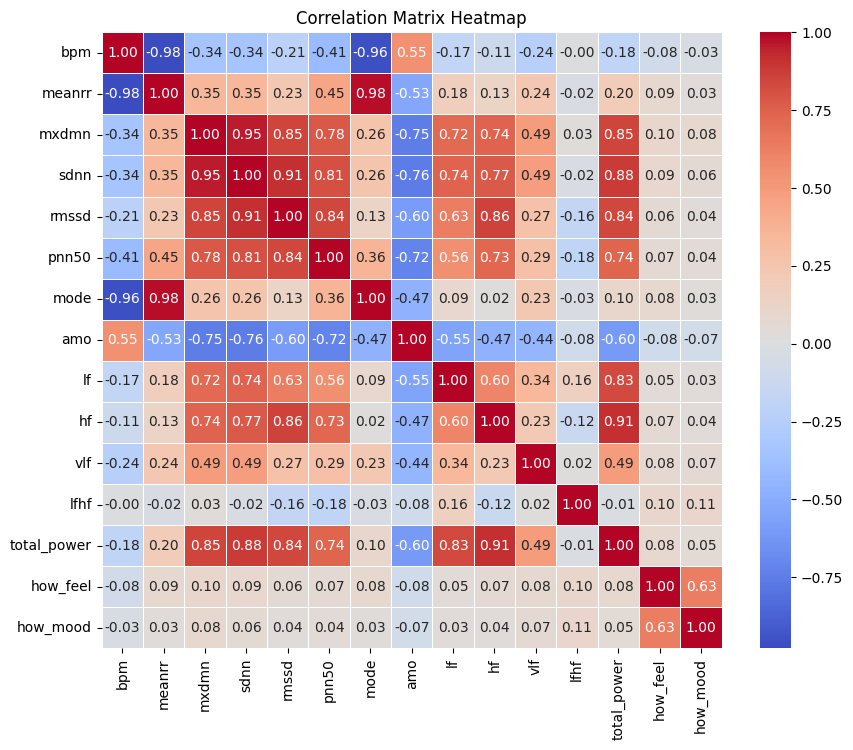

In [225]:
# Variable Relationships
print("\nVariable Relationships")
print("----------------------")
print("Correlation Matrix:")
correlation_matrix = df_hrv[df_hrv.select_dtypes(include=[np.number]).columns].corr()
print(correlation_matrix)

# Visualize the Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Interpretation**

From the above features, heart rate (bpm) is the most critical feature.

Heart rate (bpm) shows a strong negative correlation with meanrr (-0.977) and significant relationships with variability metrics like SDNN (-0.341) and RMSSD (-0.214), indicating that higher heart rates are associated with lower heart rate variability.

Meanrr correlates positively with both SDNN (0.348) and RMSSD (0.231), suggesting that lower heart rates align with better heart rate variability.

SDNN and RMSSD demonstrate a strong positive correlation (0.909), reflecting similar underlying physiological processes, while PNN50 also shows strong correlations with SDNN (0.810) and RMSSD (0.843).

These features seem to provide valuable insights and can be further explored in identifying patterns or subgroups within the data.